# Explore Spotify API

Here are some basic use cases of using Spotify API to retrieve data. Please refer to [official documenation](https://developer.spotify.com/documentation/web-api/) for more details.

To store your credentials without hardcoding into the code, please create a text file named `.env` with two lines (not included in this repo):
> CLIENT_ID = [YOUR_CLIENT_ID]  
> CLIENT_SECRET = [YOUR_CLIENT_SECRET]

In [1]:
# Import libraries
import requests
import os
from dotenv import load_dotenv
import json 
import base64
import pandas as pd

load_dotenv()
client_id = os.getenv('client_id')
client_secret = os.getenv('client_secret')

We create a function to get token with client id and secret. The token is used for GET requests later.

In [2]:
def get_token():
    auth_string = client_id + ':' + client_secret
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')
    
    url = 'https://accounts.spotify.com/api/token'
    headers = {
    'Authorization': 'Basic ' + auth_base64,
    'Content_Type': 'application/x-www-form-urlencoded'
    }
    data = {'grant_type': 'client_credentials'}
    result = requests.post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result['access_token']
    return token    

token = get_token()

## Use case 1: Get top tracks of an artist

In this case, we create two functions:
- `search_artist` to return the artist id and some basic information with artist name as input
- `get_top_tracks` to return the 10 most popular tracks of this artist 

In this example I use my favorite singer at17, a folk pop group based in Hong Kong. And the results will match the Popular section of its Spotify page:

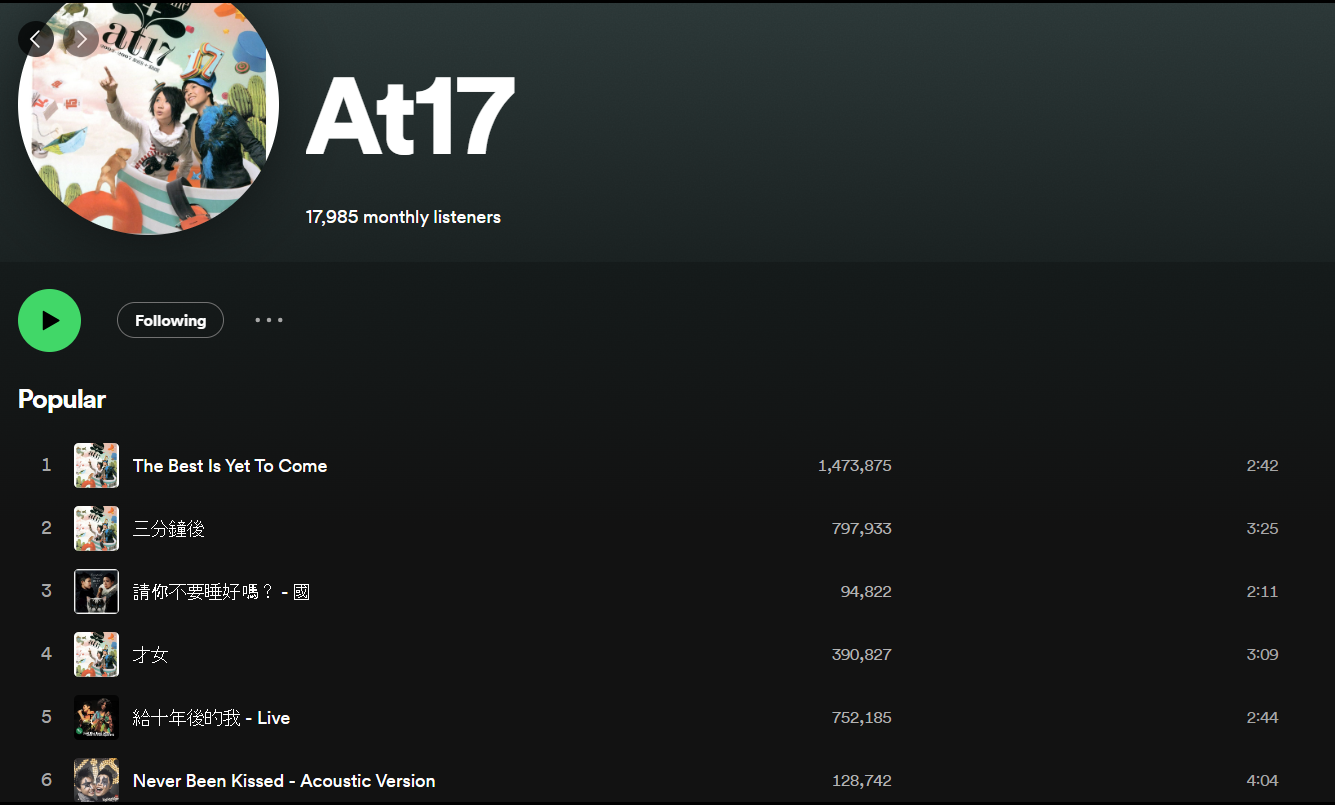

In [3]:
# Search artist - return artist id
def search_artist(token, artist_name):
    endpoint = 'https://api.spotify.com/v1/search'
    headers = {'Authorization': f'Bearer {token}'}
    query = f'?q={artist_name}&type=artist&limit=1'
    result = requests.get(endpoint + query, headers = headers)
    # json_result = json.loads(result.content)['artists']['items']
    json_result = result.json()['artists']['items'][0]
    
    if len(json_result) == 0:
        print('Not found')
        return None
    else:
        artist_id = json_result["id"]
        print(f'Name: {json_result["name"]}')
        print(f'id: {json_result["id"]}')
        print(f'Genres: {json_result["genres"]}')
        print(f'Followers: {json_result["followers"]["total"]}')
        print(f'Popularity: {json_result["popularity"]}')
    
    return artist_id

In [4]:
# Return top tracks of an artist
def get_top_tracks(token, artist_id):
    endpoint = f'https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=GB'
    headers = {'Authorization': f'Bearer {token}'}
    result = requests.get(endpoint, headers = headers)
    # json_result = json.loads(result.content)['tracks']
    # Check if the request was successful
    if result.status_code != 200:
        print(f'Error: {result.json()["error"]["message"]}')
        
    json_result = result.json()['tracks']
    return json_result

In [5]:
artist_name = 'at17'
artist_id = search_artist(token, artist_name)

Name: At17
id: 21Ep61xfoCPTDMMPPy0i0z
Genres: ['cantopop', 'chinese indie', 'hong kong indie']
Followers: 22780
Popularity: 23


In [6]:
songs = get_top_tracks(token, artist_id)
for idx, song in enumerate(songs):
    print(f'{idx + 1}:{song["name"]}')

1:The Best Is Yet To Come
2:三分鐘後
3:請你不要睡好嗎？ - 國
4:才女
5:給十年後的我 - Live
6:Never Been Kissed - Acoustic Version
7:女扮男生
8:始終一天
9:弱水三千 - Live
10:他和她的事情


## Use case 2: Get information of a playlist

In this example, we get the tracks and their information from a playlist, and put it in a dataframe. We use a popular Lofi Girl playlist in this example. The playlist id can be found in the Spotify link of that playlist.

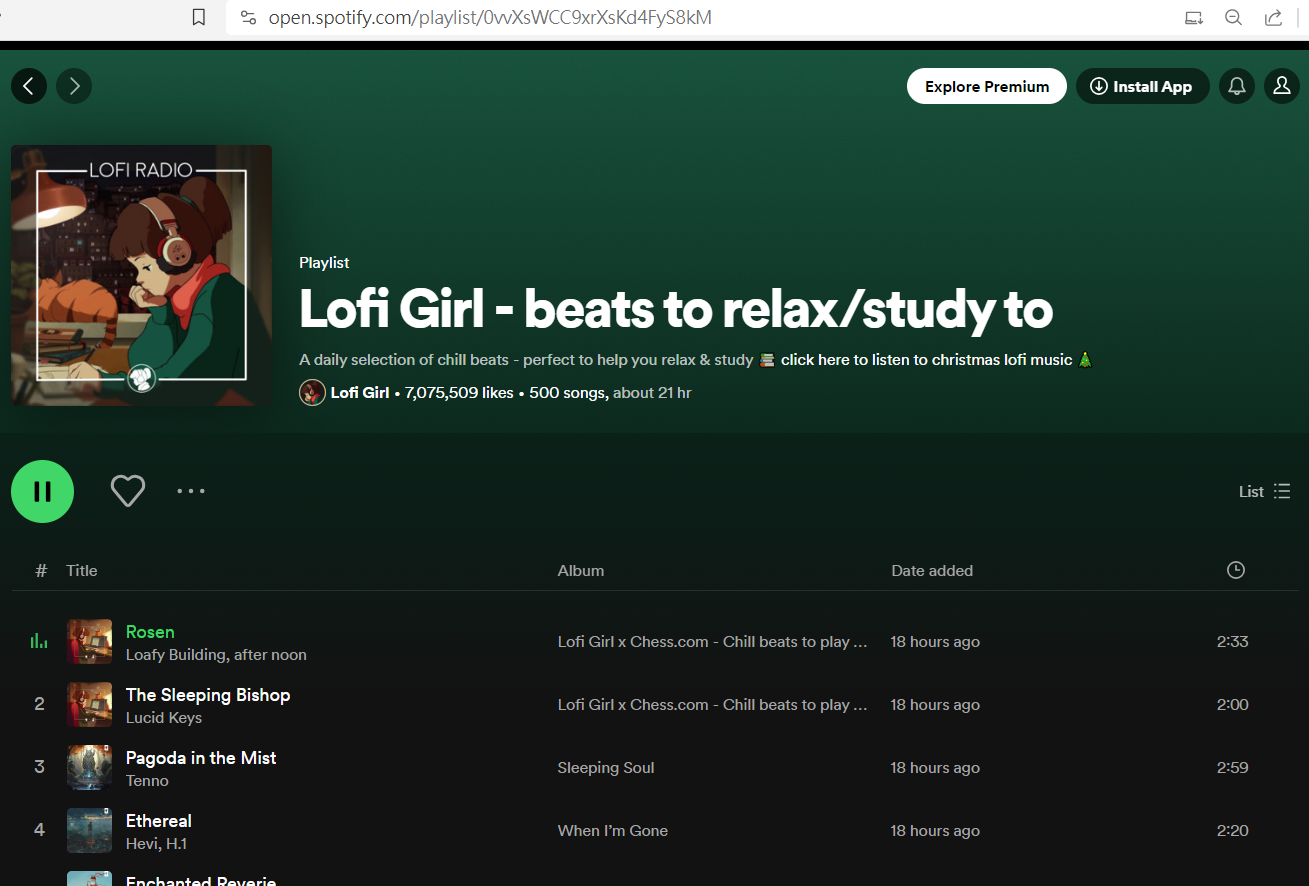

In [7]:
def get_tracks_from_playlist(token, playlist_id):
    endpoint = f'https://api.spotify.com/v1/playlists/{playlist_id}'
    headers = {'Authorization': f'Bearer {token}'}
    result = requests.get(endpoint, headers = headers)
    result_json = result.json()
    print(result_json['name'])
    return result_json['tracks']['items']

In [8]:
playlist_id = '0vvXsWCC9xrXsKd4FyS8kM' 
tracks = get_tracks_from_playlist(token, playlist_id)

Lofi Girl - beats to relax/study to


In [9]:
# Get track name, artist name(s), popularity, duration for each track and put into a dataframe
data = {'track_name':[], 'artist_name':[], 'duration':[], 'popularity':[]}

for track in tracks:    
    data['track_name'].append(track['track']['name'])
    # artist_name - with multiple artists
    artist_list = []
    for artist in track['track']['artists']:
        artist_list.append(artist['name'])
    data['artist_name'].append(artist_list)
    data['duration'].append(track['track']['duration_ms'])
    data['popularity'].append(track['track']['popularity'])

In [10]:
df = pd.DataFrame.from_dict(data)

In [11]:
df.sort_values('popularity', ascending=False).head(10)

,track_name,artist_name,duration,popularity
81,Eisinsel,"[Tibeauthetraveler, Dario Lessing]",204730,55
54,to fall,"[Towerz, edelwize]",127234,55
4,Enchanted Reverie,"[Tibeauthetraveler, Dario Lessing]",191428,55
37,Dying Language,[Nadav Cohen],211578,54
62,Rainy Day,[Nadav Cohen],178285,54
16,Eternal Garden,"[Nadav Cohen, Emma Jaffa]",151010,54
76,Regenbogenwunder,"[Tibeauthetraveler, Dario Lessing, Claudia Les...",168859,54
50,Lonely Castle,"[Tibeauthetraveler, Dario Lessing]",170182,54
87,Endurance,[Kupla],201137,54
93,Connected Spirits,[Nadav Cohen],143142,54
